# Data Processing

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from src.helpers import make_aesthetic, cat_stats, array_stats

mypal = make_aesthetic()

# Load raw Qualtrics data
df = pd.read_csv("../data/raw/ballot_September 29, 2025_17.23.csv")
df = df.iloc[2:]  # drop metadata rows
print(df.columns)

data_points = []

# Correct answers (as strings)
truth_answers = {
    1: "TRUE",
    2: "FALSE",
    3: "TRUE",
    4: "FALSE",
    5: "TRUE"
}

for idx, row in df.iterrows():
    pid = row["pid"]

    # --- Pre measures ---
    pre_data = {
        "pid": pid,
        "pre_confident": row["pre_confident_1"],
        "pre_counter": row["pre_counter"],
        "pre_would_vote": row["would_vote_1"],
        "pre_vote": row["pre_vote"],
    }

    # Add all pre_true_false_X columns
    for c in [c for c in df.columns if c.startswith("pre_true_false_")]:
        pre_data[c] = row[c]

    # Pre correctness score
    pre_score = 0
    for i, correct in truth_answers.items():
        col = f"pre_true_false_{i}"
        val = str(row.get(col)).strip().upper() if pd.notna(row.get(col)) else None
        if val == correct:
            pre_score += 1
    pre_data["pre_truth_score"] = pre_score

    # --- Condition ---
    if not pd.isna(row.get("deb_vote")):
        condition, post_prefix = "debate", "deb_"
    elif not pd.isna(row.get("steel_vote")):
        condition, post_prefix = "steel", "steel_"
    else:
        condition, post_prefix = None, None

    # --- Post measures ---
    if condition:
        post_data = {
            "post_would_vote": row.get(post_prefix + "would_vote_1"),
            "post_vote": row.get(post_prefix + "vote"),
            "post_confident": row.get(post_prefix + "confident_1"),
            "post_counter": row.get(post_prefix + "counter"),
            "feedback": row.get("goal")
        }

        # Add all post_true_false_X columns
        for c in [c for c in df.columns if c.startswith(post_prefix + "true_false_")]:
            post_data[c.replace(post_prefix, "post_")] = row[c]

        # Post correctness score
        post_score = 0
        for i, correct in truth_answers.items():
            col = f"{post_prefix}true_false_{i}"
            val = str(row.get(col)).strip().upper() if pd.notna(row.get(col)) else None
            if val == correct:
                post_score += 1
        post_data["post_truth_score"] = post_score

        # Merge everything
        data_point = {**pre_data, **post_data, "condition": condition}
        data_points.append(data_point)

# --- Final dataframe ---
df_clean = pd.DataFrame(data_points).reset_index(drop=True)

# Convert post_counter (stored like "1.0") to int if needed
df_clean["post_counter"] = df_clean["post_counter"].apply(
    lambda x: int(str(x)[0]) if pd.notna(x) else None
)
df_clean['pre_counter'] = df_clean['pre_counter'].apply(
    lambda x: int(str(x)[0]) if pd.notna(x) else None
)

# Diff scores
diff_cols = ["confident", "truth_score", "would_vote", "counter"]
for col in diff_cols:
    df_clean[f"diff_{col}"] = (
        df_clean[f"post_{col}"].astype(float) - df_clean[f"pre_{col}"].astype(float)
    )

# Look at switchers
df_clean['switch'] = (
    (df_clean['pre_vote'] != df_clean['post_vote']) &
    df_clean['pre_vote'].notna() &
    df_clean['post_vote'].notna()
)

# Position value (signed confidence)
df_clean['pre_position_sign'] = df_clean['pre_vote'].map({'Yes': 1, 'No': -1})
df_clean['post_position_sign'] = df_clean['post_vote'].map({'Yes': 1, 'No': -1})
df_clean['pre_position_val'] = df_clean['pre_position_sign'] * df_clean['pre_confident'].astype(float)
df_clean['post_position_val'] = df_clean['post_position_sign'] * df_clean['post_confident'].astype(float)

df_clean['pre_signed_conf'] = df_clean['pre_position_val']
df_clean['post_signed_conf'] = df_clean['post_position_val']


df_clean['diff_position_val'] = df_clean['post_position_val'] - df_clean['pre_position_val']
df_clean['diff_signed_conf'] = df_clean['diff_position_val'].abs()

# which true/false hard?
truth_cols = [f"pre_true_false_{i}" for i in range(1, 6)] + [f"post_true_false_{i}" for i in range(1, 6)]
for col in truth_cols:
    correct_col_indicator = col + "_correct"
    df_clean[correct_col_indicator] = df_clean.apply(
        lambda row: (
            str(row[col]).strip().upper() == truth_answers[int(col.split('_')[-1])]
            if pd.notna(row[col]) else None
        ),
        axis=1
    )




Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q2', 'pid', 'would_vote_1',
       'pre_vote', 'pre_confident_1', 'pre_counter', 'pre_true_false_1',
       'pre_true_false_2', 'pre_true_false_3', 'pre_true_false_4',
       'pre_true_false_5', 'deb_would_vote_1', 'deb_vote', 'deb_confident_1',
       'deb_counter', 'deb_true_false_1', 'deb_true_false_2',
       'deb_true_false_3', 'deb_true_false_4', 'deb_true_false_5',
       'steel_would_vote_1', 'steel_vote', 'steel_confident_1',
       'steel_counter', 'steel_true_false_1', 'steel_true_false_2',
       'steel_true_false_3', 'steel_true_false_4', 'steel_true_false_5',
       'goal'],
      dtype='object')


# Did anyone switch?

<Axes: title={'left': 'Switchers: (n=4, 10.8%)'}, xlabel='post_vote', ylabel='pre_vote'>

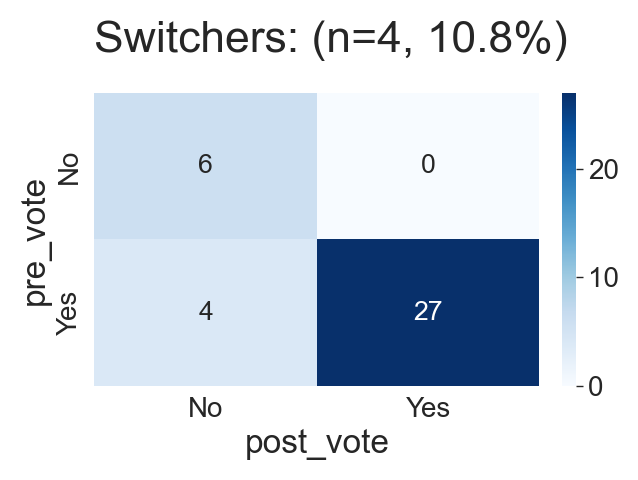

In [53]:
import seaborn as sns
import pandas as pd

ct = pd.crosstab(df_clean['pre_vote'], df_clean['post_vote'])
n_switch = df_clean['switch'].sum()
percent_switch = 100 * n_switch / len(df_clean)
plt.title(f"Switchers: (n={n_switch}, {percent_switch:.1f}%)")

sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")

## Who are the switchers?

In [54]:
switchers = df_clean[df_clean['switch']]
for idx, row in switchers.iterrows():
    print("Condition: {}, Confidence: {} -> {}, Truth score: {} -> {}, Counter: {} -> {}, Would vote: {} -> {}".format(
        row['condition'],
        row['pre_confident'], row['post_confident'],
        row['pre_truth_score'], row['post_truth_score'],
        row['pre_counter'], row['post_counter'],
        row['pre_would_vote'], row['post_would_vote']
    ))

Condition: debate, Confidence: 65 -> 30, Truth score: 5 -> 5, Counter: 6 -> 7, Would vote: 40 -> -10
Condition: debate, Confidence: 84 -> 96, Truth score: 5 -> 5, Counter: 4 -> 7, Would vote: 19 -> 40
Condition: debate, Confidence: 85 -> 95, Truth score: 5 -> 5, Counter: 5 -> 7, Would vote: 35 -> -35
Condition: debate, Confidence: 5 -> 2, Truth score: 5 -> 5, Counter: 3 -> 5, Would vote: 0 -> 0


# Change in variables by condition

In [56]:
diffd_cols = ["diff_confident", "diff_truth_score", "diff_would_vote", "diff_counter", "diff_signed_conf"]
for condition in df_clean['condition'].unique():
    print(condition.upper())

    for col in diffd_cols:
        vals = df_clean[df_clean['condition'] == condition][col].dropna()
        p_value = stats.wilcoxon(vals).pvalue
        cohen_dz = vals.mean() / vals.std() if vals.std() > 0 else np.nan
        print(f"{col}: mean={vals.mean():.2f}, sd={vals.std():.2f}, p={p_value:.3f}", f"dz={cohen_dz:.2f}")

STEEL
diff_confident: mean=0.94, sd=10.01, p=0.720 dz=0.09
diff_truth_score: mean=-0.17, sd=0.71, p=0.317 dz=-0.24
diff_would_vote: mean=-2.89, sd=11.96, p=0.462 dz=-0.24
diff_counter: mean=1.17, sd=1.54, p=0.009 dz=0.76
diff_signed_conf: mean=6.39, sd=7.62, p=0.005 dz=0.84
DEBATE
diff_confident: mean=-4.95, sd=25.66, p=0.356 dz=-0.19
diff_truth_score: mean=0.00, sd=0.33, p=1.000 dz=0.00
diff_would_vote: mean=-5.79, sd=23.23, p=0.507 dz=-0.25
diff_counter: mean=0.95, sd=1.58, p=0.019 dz=0.60
diff_signed_conf: mean=38.63, sd=55.96, p=0.000 dz=0.69


# What changes are correlated

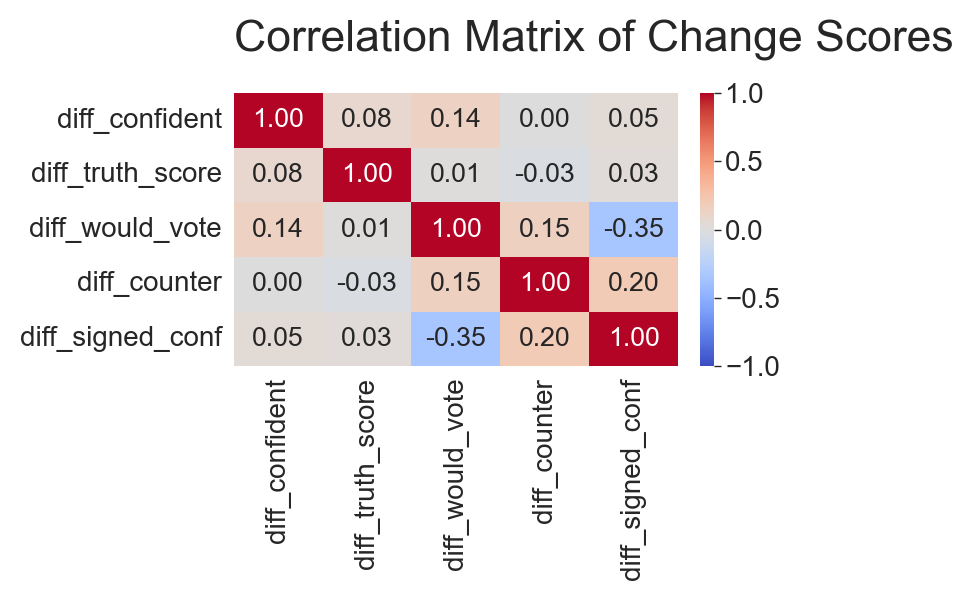

In [57]:
diffd_cols = ["diff_confident", "diff_truth_score", "diff_would_vote", "diff_counter", "diff_signed_conf"]
diff_df = df_clean[diffd_cols].dropna()
corr_matrix = diff_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Change Scores")
plt.show()

# Qualitative analysis

In [59]:
import pandas as pd
from src.sbert_cluster import SBERTClusterer

df_clean['diff_signed_conf'] = pd.qcut(
    df_clean['diff_signed_conf'],
    q=2,
    labels=['small', 'large'],
    duplicates='drop'   # handle duplicate bin edges
)

clusterer = SBERTClusterer(sbert_model='all-MiniLM-L6-v2')

for q in df_clean['diff_signed_conf'].dropna().unique():
    texts = df_clean[df_clean['diff_signed_conf'] == q]['feedback'].dropna().tolist()
    texts = [t for t in texts if len(t.split()) >= 10]  # remove empty


    print(f"\n=== Cluster analysis for {q} change in position value (n={len(texts)}) ===")

    # Find best_k for this group
    best_k = clusterer.find_k(texts, k_min=3, k_max=6, plot=False)

    # Apply clustering
    clustered_df = clusterer.apply_clustering(texts, k=best_k)

    # Print cluster summaries
    summary = clusterer.get_cluster_summary()
    print("===================================\n\n\n"*3)



=== Cluster analysis for small change in position value (n=18) ===
Best k: 3 with silhouette score: 0.093

Cluster 0 (Centroid: 'It did give me some viewpoints that I was not familiar with, because I don't know that much about taxing animal feed in the agriculture industry. However, each counter for each proposition made me still waver in my opinion.'):
 - It really helped me to understand the potential downsides of this proposed amendment. I understand the concern about funding for schools and roads - but I think the top 1% can be taxed to pay for this. Also, the roads in the U.S. have always been terrible and car-dependent. I like that there was a counter-argument to each point risen.

 - It did give me some viewpoints that I was not familiar with, because I don't know that much about taxing animal feed in the agriculture industry. However, each counter for each proposition made me still waver in my opinion.

 - My opinion was already set before the AI conversation. As a child of a 

cluster
0    34
1     2
2     1
Name: count, dtype: int64
cluster
0    91.9
1     5.4
2     2.7
Name: count, dtype: float64


/var/folders/4r/zf8yg_9n3qn26k_y7w56_gqr0000gp/T/ipykernel_35726/770572736.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


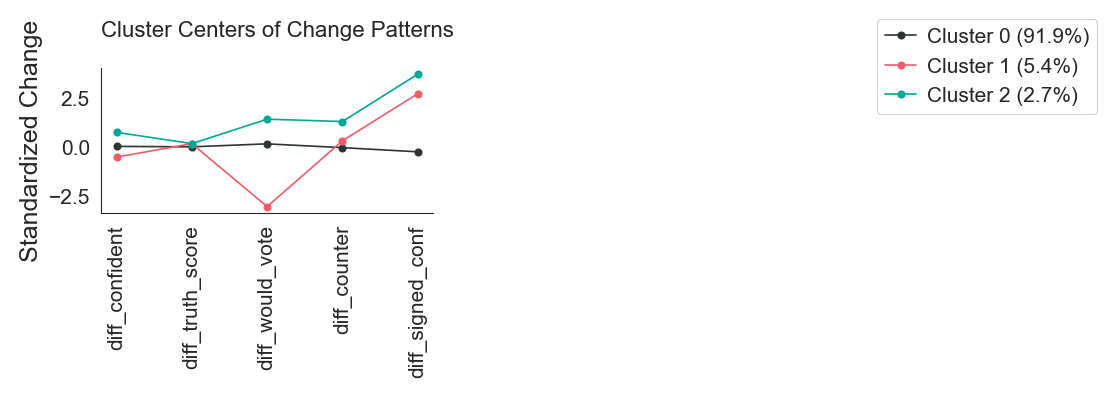

In [72]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

mypal = make_aesthetic(font_scale=1.5)

# Standardize change scores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(diff_df)

# Choose number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
diff_df['cluster'] = kmeans.fit_predict(X_scaled)

# View cluster sizes and percentages
cluster_counts = diff_df['cluster'].value_counts().sort_index()
cluster_percents = 100 * cluster_counts / len(diff_df)

print(cluster_counts)
print(cluster_percents.round(1))

# Visualize cluster centers
plt.figure(figsize=(8, 4))
for i, center in enumerate(kmeans.cluster_centers_):
    label = f'Cluster {i} ({cluster_percents[i]:.1f}%)'
    plt.plot(diffd_cols, center[:len(diffd_cols)], marker='o', label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', bbox_transform=plt.gcf().transFigure, frameon=True)
plt.xticks(rotation=90)
plt.title('Cluster Centers of Change Patterns', fontsize=16)
plt.ylabel('Standardized Change')
plt.tight_layout()
plt.show()


# Ballot analysis

In [40]:
df = pd.read_csv('../data/clean/ncslballotmeasures.csv', engine='python', encoding='latin1')

import pandas as pd

# drop missing, compute margin
df = df.dropna(subset=['pctyesvotes'])
df['yes_votes'] = df['pctyesvotes'].astype(float)
df['margin'] = df['yes_votes'] - 50.0
df['abs_margin'] = df['margin'].abs()

# thresholds
margin_within_vals = list(range(1, 20))

# compute percentages
rows = []
n_total = len(df)
for m in margin_within_vals:
    n_within = (df['abs_margin'] <= m).sum()
    pct_within = 100 * n_within / n_total
    rows.append({"margin_within": m, "pct_measures": pct_within})

table = pd.DataFrame(rows)




7531


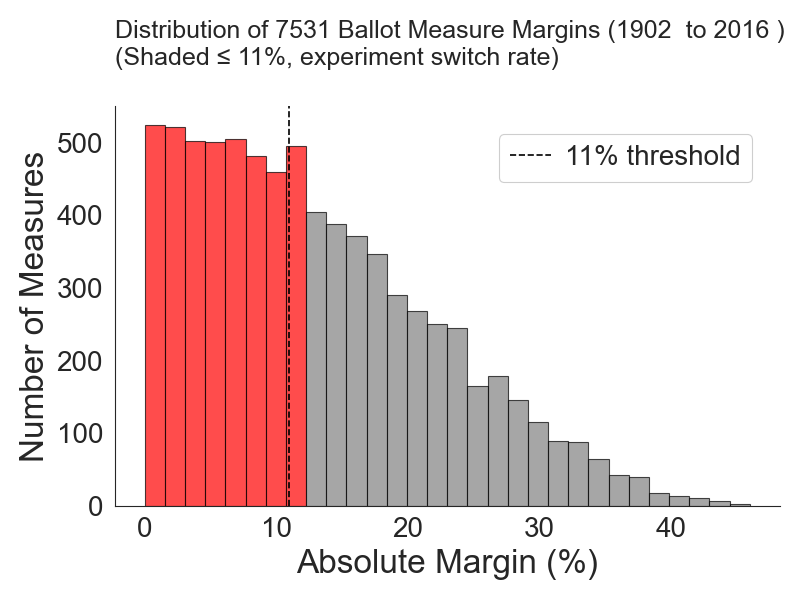

In [50]:
import pandas as pd
import matplotlib.pyplot as plt



plt.figure(figsize=(8,6))
counts, bins, patches = plt.hist(df['abs_margin'], bins=30, edgecolor='black', alpha=0.7)

# Shade bars where margin <= 11%
for patch, left_edge in zip(patches, bins[:-1]):
    if left_edge <= 11:
        patch.set_facecolor('red')
    else:
        patch.set_facecolor('gray')

min_year = df['year'].min()
max_year = df['year'].max()
n_measures = len(df)

plt.axvline(11, color='black', linestyle='--', label="11% threshold")
plt.xlabel("Absolute Margin (%)")
plt.ylabel("Number of Measures")
plt.title(f"Distribution of {n_measures} Ballot Measure Margins ({min_year} to {max_year}) \n(Shaded ≤ 11%, experiment switch rate)", fontsize=18)
plt.legend()
plt.show()



In [ ]:
4/24

In [48]:
df

,ballotid,st,state,stateno,state_fips,state_icpsr,year,ballotname,ballotdescrip,type,...,tribalrelat,tax_rev,telecom_it,termlimits,transportation,cumulbystate,totalbystate,yes_votes,margin,abs_margin
0,AL1,AL,Alabama,1.0,1,41,1992,Amendment 1,Forever Wild Land Trust Act,Legislative Referendum,...,0,0,0,0,0,1,127,56.099998,6.099998,6.099998
1,AL2,AL,Alabama,1.0,1,41,1992,Amendment 2,Pell City Board of Education,Legislative Referendum,...,0,0,0,0,0,2,127,80.099998,30.099998,30.099998
2,AL3,AL,Alabama,1.0,1,41,1994,Amendment 4-P,Chambers County Property Tax Increase for Library,Legislative Referendum,...,0,1,0,0,0,3,127,41.400002,-8.599998,8.599998
3,AL4,AL,Alabama,1.0,1,41,1994,Amendment 3-P,Decatur City Board of Education,Legislative Referendum,...,0,0,0,0,0,4,127,41.599998,-8.400002,8.400002
4,AL5,AL,Alabama,1.0,1,41,1994,Amendment 2-P,Dotham City Board of Education,Legislative Referendum,...,0,0,0,0,0,5,127,45.799999,-4.200001,4.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7767,WY37,WY,Wyoming,50.0,56,68,2012,Amendment C,Constitutional Amendment to Expand Authority o...,Legislative Referendum,...,0,0,0,0,0,37,41,49.000000,-1.000000,1.000000
7768,WY38,WY,Wyoming,50.0,56,68,2012,Amendment A,Health Care Freedom,Legislative Referendum,...,0,0,0,0,0,38,41,72.599998,22.599998,22.599998
7769,WY39,WY,Wyoming,50.0,56,68,2012,Amendment B,"Right to Hunt, Fish and Trap",Legislative Referendum,...,0,0,0,0,0,39,41,84.800003,34.800003,34.800003
7770,WY40,WY,Wyoming,50.0,56,68,2014,Constitutional Amendment A,University of Wyoming Trustees,Legislative Referendum,...,0,0,0,0,0,40,41,29.700001,-20.299999,20.299999
